In [2]:
import graspy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
#uncomment when placed into model folder not doc
#from .base import BaseGraphEstimator, _calculate_p

from scipy.stats import bernoulli 
import pandas as pd 

from graspy.simulations import sbm, er_np, er_nm
from graspy.plot import heatmap

from graspy.models.base import BaseGraphEstimator 
from graspy.utils.utils import (
    augment_diagonal,
    cartprod,
    import_graph,
    is_unweighted,
    remove_loops,
    symmetrize,
)

%matplotlib inline

In [3]:
class SIEMEstimator(BaseGraphEstimator):
    r"""
    Stochastic Block Model 
    The stochastic block model (SBM) represents each node as belonging to a block 
    (or community). For a given potential edge between node :math:`i` and :math:`j`, 
    the probability of an edge existing is specified by the block that nodes :math:`i`
    and :math:`j` belong to:
    :math:`P_{ij} = B_{\tau_i \tau_j}`
    where :math:`B \in \mathbb{[0, 1]}^{K x K}` and :math:`\tau` is an `n\_nodes` 
    length vector specifying which block each node belongs to. 
    Read more in the :ref:`tutorials <models_tutorials>`
    Parameters
    ----------
    directed : boolean, optional (default=True)
        Whether to treat the input graph as directed. Even if a directed graph is inupt, 
        this determines whether to force symmetry upon the block probability matrix fit
        for the SBM. It will also determine whether graphs sampled from the model are 
        directed. 
    loops : boolean, optional (default=False)
        Whether to allow entries on the diagonal of the adjacency matrix, i.e. loops in 
        the graph where a node connects to itself. 
    n_components : int, optional (default=None)
        Desired dimensionality of embedding for clustering to find communities.
        ``n_components`` must be ``< min(X.shape)``. If None, then optimal dimensions 
        will be chosen by :func:`~graspy.embed.select_dimension``.
    min_comm : int, optional (default=1)
        The minimum number of communities (blocks) to consider. 
    max_comm : int, optional (default=10)
        The maximum number of communities (blocks) to consider (inclusive).
    cluster_kws : dict, optional (default={})
        Additional kwargs passed down to :class:`~graspy.cluster.GaussianCluster`
    embed_kws : dict, optional (default={})
        Additional kwargs passed down to :class:`~graspy.embed.AdjacencySpectralEmbed`
    Attributes
    ----------
    block_p_ : np.ndarray, shape (n_blocks, n_blocks)
        The block probability matrix :math:`B`, where the element :math:`B_{i, j}`
        represents the probability of an edge between block :math:`i` and block 
        :math:`j`.
    p_mat_ : np.ndarray, shape (n_verts, n_verts)
        Probability matrix :math:`P` for the fit model, from which graphs could be
        sampled.
    vertex_assignments_ : np.ndarray, shape (n_verts)
        A vector of integer labels corresponding to the predicted block that each node 
        belongs to if ``y`` was not passed during the call to ``fit``. 
    block_weights_ : np.ndarray, shape (n_blocks)
        Contains the proportion of nodes that belong to each block in the fit model.
    See also
    --------
    graspy.simulations.siem
    References
    ----------
    .. [1]  Holland, P. W., Laskey, K. B., & Leinhardt, S. (1983). Stochastic
            blockmodels: First steps. Social networks, 5(2), 109-137.
    """
    def __init__(
        self,
        directed=True,
        loops=False,
#         n_components=None,
#         min_comm=1,
#         max_comm=10,
#         cluster_kws={},
#         embed_kws={},
    ):
        super().__init__(directed=directed, loops=loops)
        self.model = {}
#         _check_common_inputs(n_components, min_comm, max_comm, cluster_kws, embed_kws)
#         self.cluster_kws = cluster_kws
#         self.n_components = n_components
#         self.min_comm = min_comm
#         self.max_comm = max_comm
#         self.embed_kws = embed_kws
#     def _estimate_assignments(self, graph):
#         """
#         Do some kind of clustering algorithm to estimate communities
#         There are many ways to do this, here is one
#         """
#         embed_graph = augment_diagonal(graph)
#         latent = AdjacencySpectralEmbed(
#             n_components=self.n_components, **self.embed_kws
#         ).fit_transform(embed_graph)
#         if isinstance(latent, tuple):
#             latent = np.concatenate(latent, axis=1)
#         gc = GaussianCluster(
#             min_components=self.min_comm,
#             max_components=self.max_comm,
#             **self.cluster_kws
#         )
#         vertex_assignments = gc.fit_predict(latent)
#         self.vertex_assignments_ = vertex_assignments
    def fit(self, graph, edge_comm, weighted):
        """
        Fit the SIEM to a graph
        Parameters
        ----------
        graph : array_like or networkx.Graph [nxn]
            Input graph to fit
        edge_comm : 2d list of k tuples (k_communities)
            Categorical labels for the block assignments of the graph
        weighted: boolean or float
            Boolean: True - do nothing or False - ensure everything is 0 or 1
            Float: binarize and use float as cutoff
        """
        #checks
        n = graph.shape[0]
        if not(isinstance(graph, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph, np.ndarray))):
            msg = "graph must be a np.array or networkx.Graph"
            raise TypeError(msg)
        if not isinstance(edge_comm, list):
            msg = "Edge_comm must be a list"
            raise TypeError(msg)
        if len(edge_comm) >= n:
            msg = "warning more communities than n vertices"
            print(msg)
        if len(edge_comm) > n**2:
            msg = "Too many communities for this graph"
            raise TypeError(msg)
        if not(type(weighted) == bool or type(weighted) == float): 
            msg = "weighted must be a boolean or float"
            raise TypeError(msg)
        graph = import_graph(graph)
        if isinstance(weighted,float): 
            graph = 1*(graph>weighted)
        if weighted == False: 
            if not np.array_equal(graph, graph.astype(bool)):
                msg = "graph of weighted = False must have binary inputs"
                raise TypeError(msg)
                
                
        for i in range(0,len(edge_comm)):
            comms = []
            for x in edge_comm[i]:
                comms.append(graph[x])
                
            self.model[i] = comms
#         if not is_unweighted(graph):
#             raise NotImplementedError(
#                 "Graph model is currently only implemented for unweighted graphs."
#             )
#         if y is None:
#             self._estimate_assignments(graph)
#             y = self.vertex_assignments_
#             _, counts = np.unique(y, return_counts=True)
#             self.block_weights_ = counts / graph.shape[0]
#         else:
#             check_X_y(graph, y)
#         block_vert_inds, block_inds, block_inv = _get_block_indices(y)
#         if not self.loops:
#             graph = remove_loops(graph)
#         block_p = _calculate_block_p(graph, block_inds, block_vert_inds)
#         if not self.directed:
#             block_p = symmetrize(block_p)
#         self.block_p_ = block_p
#         p_mat = _block_to_full(block_p, block_inv, graph.shape)
#         if not self.loops:
#             p_mat = remove_loops(p_mat)
#         self.p_mat_ = p_mat
#        return self
#     def _n_parameters(self):
#         n_blocks = self.block_p_.shape[0]
#         n_parameters = 0
#         if self.directed:
#             n_parameters += n_blocks ** 2
#         else:
#             n_parameters += n_blocks * (n_blocks + 1) / 2
#         if hasattr(self, "vertex_assignments_"):
#             n_parameters += n_blocks - 1
#         return n_parameters

def siem(n, p,edge_comm, directed=False, loops=False, wt=None, wtargs=None):
    """
    Samples a graph from the structured independent edge model (SIEM) 
    SIEM produces a graph with specified communities, in which each community can
    have different sizes and edge probabilities. 
    Read more in the :ref:`tutorials <simulations_tutorials>`
    Parameters
    ----------
    n: int
        Number of vertices
    p: list of int of length K (k_communities)
        Probability of an edge existing within the corresponding communities, where p[i] indicates 
        the probability of an edge existing in the edge_comm[i]
    edge_comm: 2d list of K tuples (k_communities)
        tuple is the indices for the edge within the kth community.
    directed: boolean, optional (default=False)
        If False, output adjacency matrix will be symmetric. Otherwise, output adjacency
        matrix will be asymmetric.
    loops: boolean, optional (default=False)
        If False, no edges will be sampled in the diagonal. Otherwise, edges
        are sampled in the diagonal.
    wt: object or list of K objects (k_communities)
        if Wt is an object, a weight function to use globally over
        the siem for assigning weights. If Wt is a list, a weight function for each of
        the edge communities to use for connection strengths Wt[i] corresponds to the weight function
        for edge community i. Default of None results in a binary graph
    wtargs: dictionary or array-like, shape (k_communities)
        if Wt is an object, Wtargs corresponds to the trailing arguments
        to pass to the weight function. If Wt is an array-like, Wtargs[i, j] 
        corresponds to trailing arguments to pass to Wt[i, j].
    return_labels: boolean, optional (default = False)
        IF True, returns the edge-communities as well
    References
    ----------
    Returns
    -------
    A: ndarray, shape (sum(n), sum(n))
        Sampled adjacency matrix
    T: returns the edge-communities if return_labels == True
    Examples
    --------
    >>> np.random.seed(1)
    >>> n = [3, 3]
    >>> p = [[0.5, 0.1], [0.1, 0.5]]
    To sample a binary 2-block SBM graph:
    >>> sbm(n, p)
    array([[0., 0., 1., 0., 0., 0.],
           [0., 0., 1., 0., 0., 1.],
           [1., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0., 0.],
           [0., 1., 0., 0., 0., 0.]])
    To sample a weighted 2-block SBM graph with Poisson(2) distribution:
    >>> wt = np.random.poisson
    >>> wtargs = dict(lam=2)
    >>> sbm(n, p, wt=wt, wtargs=wtargs)
    array([[0., 4., 0., 1., 0., 0.],
           [4., 0., 0., 0., 0., 2.],
           [0., 0., 0., 0., 0., 0.],
           [1., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0.],
           [0., 2., 0., 0., 0., 0.]])
    """
    # Check n
    if not isinstance(n, (int)):
        msg = "n must be a int, not {}.".format(type(n))
        raise TypeError(msg)
    # Check edge_comm 
    if not isinstance(edge_comm, (list)):
        msg = "edge_comm must be a 2d list of length k."
        raise TypeError(msg)
    else: 
        for i in range(len(edge_comm)):
            for x in edge_comm[i]:
                if not (len(x)==2 and isinstance (x,tuple)):
                    msg = "The edge_comm list must contain tuples of 2 elements."
                    raise TypeError(msg)
        #edge_comm = np.array(edge_comm)
        #generate temporary adjacency matrix to check upper triangular?
        if (directed == True) and (loops == True):
            if not(sum(len(x) for x in edge_comm) <= n**2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2 !".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)
        elif (directed == True) and (loops == False): 
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)/2): 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == True):
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n*(n-1)) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n(n-1)!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
        elif (directed == False) and (loops == False): 
            #check symmetry ?
            if not(sum(len(x) for x in edge_comm) <= n**2/2) : 
                msg = "Edge Communities and Number of Vertices Do Not Agree, {} must be <= n**2/2!".format(sum(len(x) for x in edge_comm))
                raise ValueError(msg)            
    # Check p
    if not isinstance(p, (list, np.ndarray)):
        msg = "p must be a list or np.array, not {}.".format(type(p))
        raise TypeError(msg)
    else:
        p = np.array(p)
        if not np.issubdtype(p.dtype, np.number):
            msg = "There are non-numeric elements in p"
            raise ValueError(msg)
        elif np.any(p < 0) or np.any(p > 1):
            msg = "Values in p must be in between 0 and 1."
            raise ValueError(msg)
        elif len(p) != len(edge_comm):
            msg = "# of Probabilities and # of Communities Don't Match Up"
            raise ValueError(msg)
    # Check wt and wtargs
    if (wt is not None) and (wtargs is not None): 
        if callable(wt):
            #extend the function to size of k 
            wt = np.full(len(edge_comm), wt, dtype=object)
            wtargs = np.full(len(edge_comm), wtargs, dtype=object)
        elif type(wt) == list:
            if all(callable(x) for x in wt): 
                # if not object, check dimensions
                if len(wt) != (len(edge_comm)):
                    msg = "wt must have size k, not {}".format(len(wt))
                    raise ValueError(msg)
                if len(wtargs) != (len(edge_comm)):
                    msg = "wtargs must have size k , not {}".format(len(wtargs))
                    raise ValueError(msg)
                # check if each element is a function
                for element in wt.ravel():
                    if not callable(element):
                        msg = "{} is not a callable function.".format(element)
                        raise TypeError(msg)   
            else: 
                msg = "list must contain all callable objects"
                raise ValueError(msg)
        else:
            msg = "wt must be a callable object or list of callable objects"
            raise ValueError(msg)

    K = len(edge_comm) # the number of communities
    # End Checks, begin simulation
    A = np.zeros((n,n))

    # list of lists of 2-d tuples version
    for i in range(0, K):
        #sample bernoulli at once
        rvs = bernoulli.rvs(p[i],size = len(edge_comm[i]))
        #iterate over each index
        for x in range(len(edge_comm[i])):
            #set each equal to bernoulli 
            A[edge_comm[i][x]] = rvs[x]
            #adjust adjacency matrix with any weight args. 
            if (wt is not None) and (wtargs is not None): 
                    A[edge_comm[i][x]] = A[edge_comm[i][x]]*wt[i](**wtargs[i])
    
    if not directed:
        A = A + A.T - np.diag(A)
        
    return A


In [4]:
siem_test = SIEMEstimator(directed = True, loops = False)

In [5]:

def generate_samples(n,pq,wt = None,wtargs = None,plot = True):
    #n is number of vertices 
    #pq is true population matrix values [[p,q],[q,p]]
    m = int(n/2)
    if (wt == None) and (wtargs == None): 
        g = sbm(n = [m,m], p =pq)
    else:
        g = sbm(n = [m,m], p =pq, wt= wt,wtargs = wtargs)
    if plot:
        heatmap(g)
    #on diagonal p
    edge_comm_p = np.concatenate((np.argwhere(g[:m,:m] != 0),(np.argwhere(g[m:,m:] != 0) + m)),axis = 0) 
    #off diagnonal q
    edge_comm_q = np.concatenate(( (np.argwhere(g[m:,:m] != 0) + [m,0]),(np.argwhere(g[:m,m:] != 0) + [0,m]) ) ,axis = 0) 
    
    comms = [edge_comm_p,edge_comm_q]
    edge_comm = []
    for i in comms:
        edge_comm_list = []
        for x in range(len(i)):
            edge_comm_list.append(tuple(i[x]))
        edge_comm.append(edge_comm_list)
    
    return edge_comm

def test_probabilities(sample_data,n_k,p):
    #sample_data is dictionary of sampled data
    #n_k k array of edges in community k
    #p is k array of true probability means. 
    
    for i in range(len(p)):
        print('Sample Prob: ' + str(len(sample_data[i])/n_k[i] )   )
        print('True Population Prob: ' + str(p[i]))
    

### Test 1: Base Case Check SIEM grabs proper edges as given for Unweighted

Sample Prob: 0.474
True Population Prob: 0.5
Sample Prob: 0.096
True Population Prob: 0.1


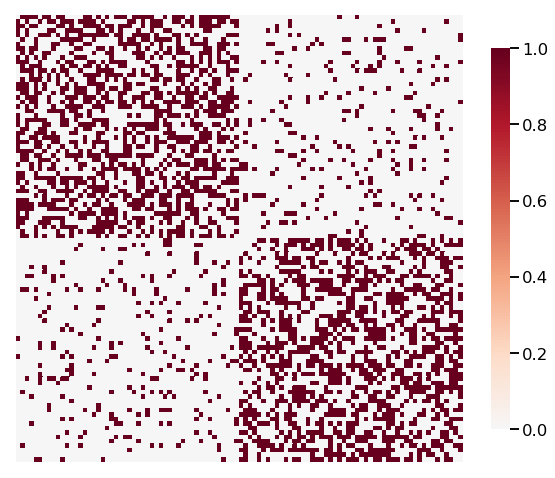

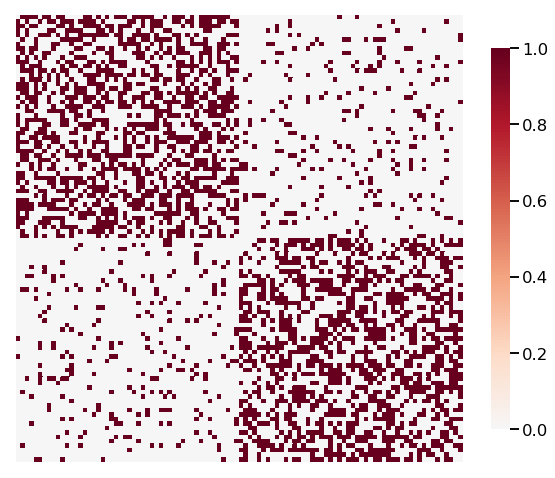

In [6]:
# p = 0.1 community
n = 100
edge_comm = generate_samples(n,[[0.5,0.1],[0.1,0.5]])

p = [1,1]
s1 = siem(n = n, p=p, directed = True, loops = False, edge_comm = edge_comm)
heatmap(s1)

siem_test = SIEMEstimator()
siem_test.fit(s1,edge_comm = edge_comm, weighted = False)
model_dict = siem_test.model
test_probabilities(model_dict,[50*50*2,50*50*2],p = [0.5,0.1])


In [7]:
### Test 1: Base Case Check SIEM grabs proper edges as given for Weighted

Sample Prob: 0.48
True Population Prob: 0.5
Sample Prob: 0.1152
True Population Prob: 0.1


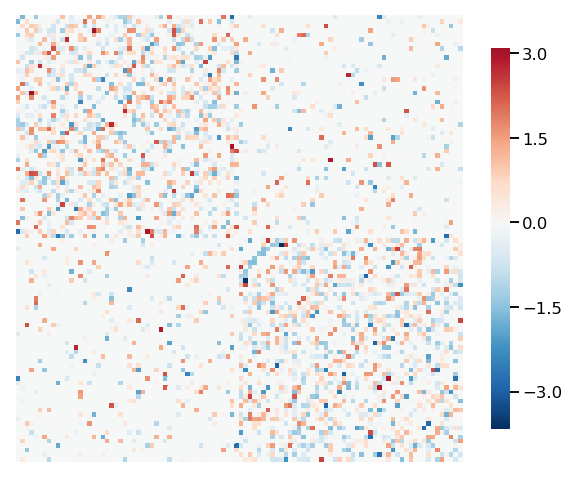

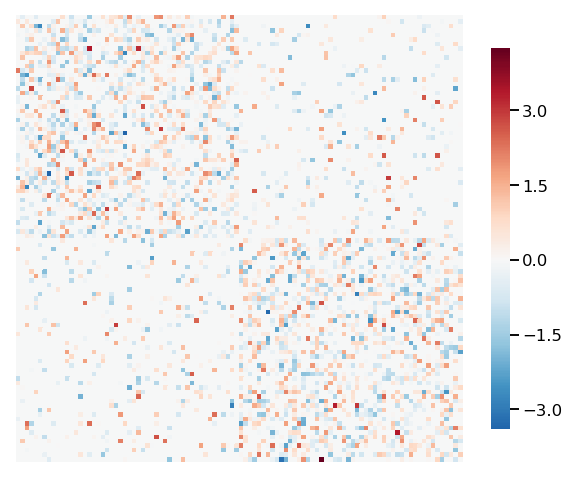

In [8]:
# p = 0.1 community
n = 100
wt = np.random.normal
wtargs = dict(loc=0, scale=1)

edge_comm = generate_samples(n,[[0.5,0.1],[0.1,0.5]],wt= wt, wtargs = wtargs)

p = [1,1]
s1 = siem(n = n, p=p, directed = True, loops = False, edge_comm = edge_comm, wt = wt, wtargs = wtargs)
heatmap(s1)

siem_test = SIEMEstimator()
siem_test.fit(s1,edge_comm = edge_comm, weighted = 0.0)
model_dict = siem_test.model
test_probabilities(model_dict,[50*50*2,50*50*2],p = [0.5,0.1])

### Unweighted N Increment Sample Testing

In [12]:
x_p = []
y_p = []
e_p = []

x_q = []
y_q = []
e_q = []


for n in range(10,500,10):
    
    # p = 0.1 community
    p_true = [0.5,0.1]
    edge_comm = generate_samples(n,[[0.5,0.1],[0.1,0.5]],plot = False)

    p = [1,1]
    s1 = siem(n = n, p=p, directed = True, loops = False, edge_comm = edge_comm)
#     heatmap(s1)

    siem_test = SIEMEstimator()
    siem_test.fit(s1,edge_comm = edge_comm, weighted = False)
    sample_data = siem_test.model
    n_k = [n/2*n/2*2,n/2*n/2*2]
    print('N = ' + str(n))
    for i in range(len(p_true)):
        print('Sample Prob: ' + str(len(sample_data[i])/n_k[i] ))
        print('True Population Prob: ' + str(p_true[i]))
    
    x_p.append(n)
    x_q.append(n)
    y_p.append(len(sample_data[0])/n_k[i])
    y_q.append(len(sample_data[1])/n_k[i])

prob_p = np.repeat(0.5,len(x_p))
prob_q = np.repeat(0.1,len(x_p))

e_p = y_p - prob_p
e_q = y_q - prob_q



N = 10
Sample Prob: 0.48
True Population Prob: 0.5
Sample Prob: 0.04
True Population Prob: 0.1
N = 20
Sample Prob: 0.5
True Population Prob: 0.5
Sample Prob: 0.1
True Population Prob: 0.1
N = 30
Sample Prob: 0.49777777777777776
True Population Prob: 0.5
Sample Prob: 0.1111111111111111
True Population Prob: 0.1
N = 40
Sample Prob: 0.4575
True Population Prob: 0.5
Sample Prob: 0.0925
True Population Prob: 0.1
N = 50
Sample Prob: 0.4688
True Population Prob: 0.5
Sample Prob: 0.112
True Population Prob: 0.1
N = 60
Sample Prob: 0.48444444444444446
True Population Prob: 0.5
Sample Prob: 0.10111111111111111
True Population Prob: 0.1
N = 70
Sample Prob: 0.47836734693877553
True Population Prob: 0.5
Sample Prob: 0.10285714285714286
True Population Prob: 0.1
N = 80
Sample Prob: 0.490625
True Population Prob: 0.5
Sample Prob: 0.100625
True Population Prob: 0.1
N = 90
Sample Prob: 0.48641975308641977
True Population Prob: 0.5
Sample Prob: 0.09827160493827161
True Population Prob: 0.1
N = 100
Sampl

Text(0, 0.5, 'Probability')

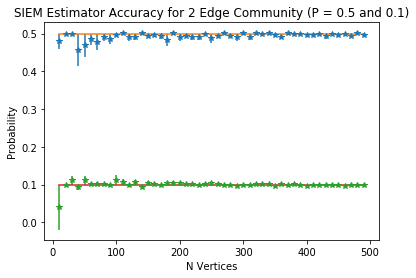

In [13]:
plt.figure()
plt.errorbar(x_p,y_p,e_p,linestyle='None', marker = '*')
plt.plot(x_p,np.repeat(0.5,len(x_p)))

plt.errorbar(x_q,y_q,e_q,linestyle='None', marker = '*')
plt.plot(x_p,np.repeat(0.1,len(x_q)))

plt.title('SIEM Estimator Accuracy for 2 Edge Community (P = 0.5 and 0.1)')
plt.xlabel('N Vertices')
plt.ylabel('Probability')

Text(0, 0.5, 'Mean Squared Error')

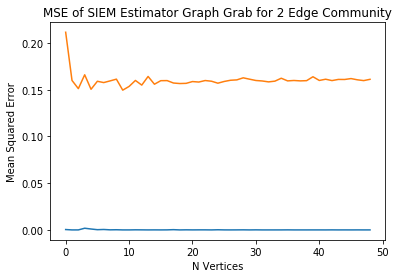

In [14]:
mse_p = (y_p - prob_p)**2

mse_q = (y_q - prob_p)**2

plt.figure()

plt.plot(mse_p)
plt.plot(mse_q)
plt.title('MSE of SIEM Estimator Graph Grab for 2 Edge Community')
plt.xlabel('N Vertices')
plt.ylabel('Mean Squared Error')